In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import pickle
from collections import Counter
from scipy import stats

In [2]:
trip = pd.read_csv('trim_bay_2min_6hours.csv', index_col=False)

In [3]:
trip.head()

,Unnamed: 0,Unnamed: 0.1,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,city
0,10,10,4549,125,2013-08-29 13:52:00,Spear at Folsom,49,2013-08-29 13:55:00,Embarcadero at Bryant,54,368,Subscriber,94109,San Francisco
1,11,11,4498,126,2013-08-29 13:23:00,San Pedro Square,6,2013-08-29 13:25:00,Santa Clara at Almaden,4,26,Subscriber,95112,San Jose
2,12,12,4965,129,2013-08-29 19:32:00,Mountain View Caltrain Station,28,2013-08-29 19:35:00,Mountain View Caltrain Station,28,140,Subscriber,94041,Mountain View
3,13,13,4557,130,2013-08-29 13:57:00,2nd at South Park,64,2013-08-29 13:59:00,2nd at South Park,64,371,Subscriber,94122,San Francisco
4,14,14,4386,134,2013-08-29 12:31:00,Clay at Battery,41,2013-08-29 12:33:00,Beale at Market,56,503,Subscriber,94109,San Francisco


In [4]:
trip.shape

(661556, 14)

In [5]:
trip = trip.drop(['Unnamed: 0', 'Unnamed: 0.1'], 1)

### check interval 

In [29]:
def collectinterval(dataset):
    #final_id_list = []
    interval_list = []
    bikeid = set(dataset.bike_id.unique())
    for bike_id in bikeid:
        temp = dataset[dataset['bike_id'] == bike_id] 
        temp.loc[:,'start_date'] =pd.to_datetime(temp['start_date'].values)
        temp.loc[:,'end_date'] =pd.to_datetime(temp['end_date'].values)
        temp = temp.sort_values(by=['start_date'])
        for i in range(1, len(temp)):
            t = ((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'm')).astype(int)
            interval_list.append(t)
        #print(bike_id)
    return interval_list

In [149]:
interval_list = collectinterval(trip)

C:\Users\Xuancheng Fan\AppData\Local\Programs\Python\Python35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [150]:
np.mean(interval_list), np.median(interval_list), np.std(interval_list)

(1019.4101165760771, 224.0, 4519.9627666765819)

In [228]:
#interval_log = np.log10(np.array(interval_list))
interval_log = np.log(np.array(interval_list))

C:\Users\Xuancheng Fan\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Xuancheng Fan\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [229]:
len(interval_log)

660856

In [230]:
interval_log = interval_log[~np.isnan(interval_log)]

In [231]:
interval_log = interval_log[~np.isinf(interval_log)]

In [232]:
np.mean(interval_log), np.median(interval_log), np.std(interval_log)

(5.2396798277805887, 5.4293456289544411, 2.0143034617539155)

In [233]:
t = np.mean(interval_log) + 2*np.std(interval_log)

In [234]:
np.power(np.e, t) / 1440  # 95%

7.3587373235193869

In [235]:
t2 = np.mean(interval_log) + (1.644)*np.std(interval_log) # 90%

In [236]:
np.power(np.e, t2) / 1440

3.5923131494606815

In [237]:
#counter_inteval = Counter(interval_list)
#counter_inteval = Counter(interval_log)

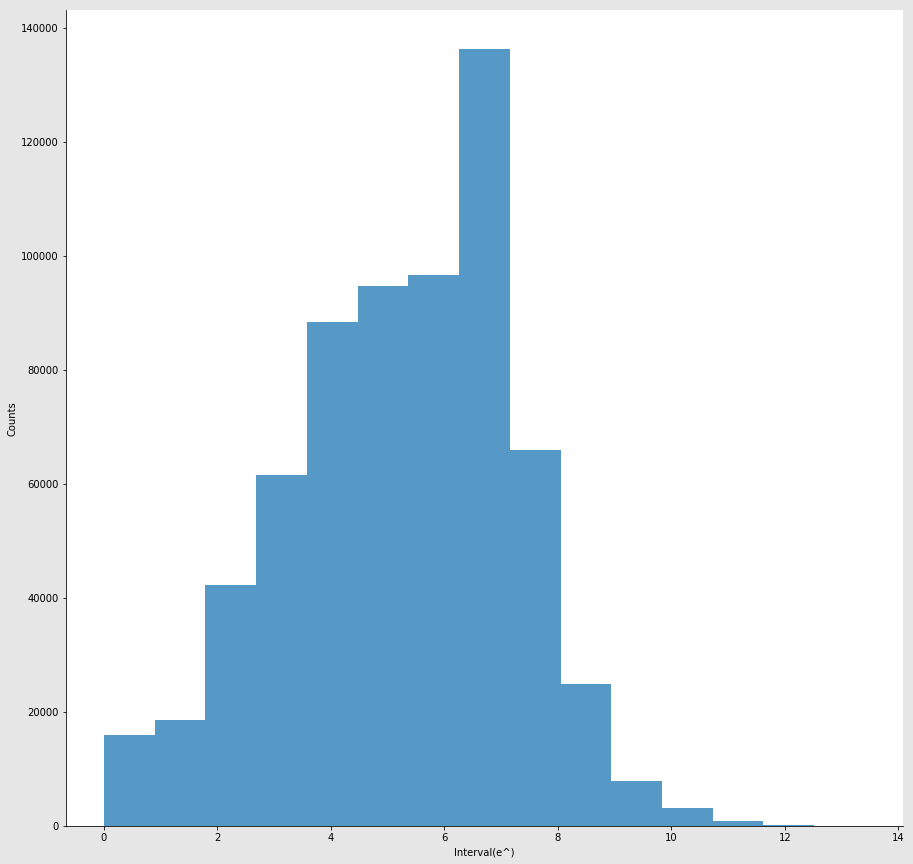

In [239]:
fig, ax = plt.subplots(figsize = [15,15], facecolor = [0.9,0.9,0.9])
labels, values = zip(*counter_inteval.items())
#plt.hist(c,facecolor='g')
indexes = np.arange(len(labels))
#plt.bar(indexes, values, 1)
plt.hist(interval_log, bins=15, alpha=0.75)
plt.xlabel('Interval(e^)')
plt.ylabel('Counts')
#plt.title('Bay')
#plt.axis([0, 10000, 0, 1000000])
#plt.grid(True)
#ax.set_xlim([0, 20])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

### Lifecycle

In [11]:
def tempcovert(temp):
    # convert the bike_id according to the lifecycle, e.g., 19 -> 19_1, 19_2, 19_3
    # condition: interval > 7days and start_station != last end_station
    # final_id: the last seen id, e.g., 19_3, since it is possible the life_cycle of this id does not end
    final_id_list = []
    bike_group = []
    counts = 0
    for i in range(len(temp)):
        old_id = temp.iloc[i].bike_id
        if i == 0:
            bike_group.append(str(old_id) +'_'+str(counts))
            #print(i, temp.iloc[i].bike_id)
        elif i == len(temp)-1:
            bike_group.append(str(old_id) +'_'+str(counts)) 
            final_id = str(old_id) +'_'+str(counts) 
            #temp = temp[temp.bike_id != final_id]
            final_id_list.append(final_id)
            print(final_id)
        else:
            if (((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'D')).astype(int) > 4 and
               temp.iloc[i].start_station_id != temp.iloc[i-1].end_station_id):
                counts += 1
            elif ((temp.iloc[i].start_date-temp.iloc[i-1].end_date)/np.timedelta64(1, 'D')).astype(int) > 7:
                counts += 1
            bike_group.append(str(old_id) +'_'+str(counts)) 
            #print(i, temp.iloc[i].bike_id)
    result = pd.DataFrame(bike_group, columns = ['bike_group'], index=temp.index)
    temp = pd.concat([temp, result], axis =1)
    
    return temp, final_id

In [12]:
def generatelifecycle(dataset):
    new_pd = pd.DataFrame()
    finalid_list = []
    id_set = set(dataset.bike_id.unique())
    for bikeid in id_set:
        temp = dataset[dataset['bike_id'] == bikeid]
        temp.sort_values(by=['start_date'])
        temp['start_date'] =pd.to_datetime(temp['start_date'].values)
        temp['end_date'] =pd.to_datetime(temp['end_date'].values)
        temp, final_id = tempcovert(temp)
        new_pd = pd.concat([new_pd, temp])
        finalid_list.append(final_id)
        
    return new_pd, finalid_list

In [13]:
#dataset = trip[trip.bike_id.isin({9,10})]

In [14]:
new_pd, finalid_list = generatelifecycle(trip)

C:\Users\Xuancheng Fan\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Xuancheng Fan\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


9_3
10_7
11_12
12_7
13_9
14_11
15_7
16_4
17_8
18_6
19_7
20_12
21_8
22_8
23_7
24_6
25_8
26_13
27_10
28_9
29_8
30_9
31_8
32_6
33_1
34_7
35_7
36_11
37_6
38_11
39_9
40_10
41_10
42_6
43_9
44_10
45_5
46_9
47_12
48_6
49_12
50_8
51_14
52_13
53_7
54_7
55_10
56_11
57_5
58_12
59_11
60_6
61_12
62_7
63_11
64_10
65_7
66_6
67_7
68_9
69_8
70_5
71_8
72_10
74_8
75_6
76_9
77_10
78_10
79_12
80_7
81_11
82_13
83_6
84_7
85_7
86_12
87_13
88_11
89_6
90_8
91_8
92_10
93_13
94_6
95_11
96_9
97_9
98_8
99_9
100_10
101_6
102_7
103_9
104_7
105_6
106_6
107_7
108_9
109_9
110_3
111_6
112_9
116_6
117_10
118_9
119_10
120_11
121_12
122_5
123_7
124_8
125_6
126_10
127_8
128_11
129_13
130_9
131_7
132_10
133_8
134_7
135_6
136_6
137_7
138_10
139_10
140_8
141_7
142_10
143_10
144_9
145_6
146_9
147_6
148_9
149_9
150_11
151_10
152_3
153_9
154_8
155_8
156_7
157_8
158_8
159_11
160_12
161_11
162_7
163_8
164_8
165_8
167_7
168_8
174_10
175_7
176_7
177_11
178_7
179_8
180_9
181_7
182_8
183_3
184_8
185_8
186_7
187_11
188_8
189_1
190_5
191_6

KeyboardInterrupt: 

In [ ]:
new_pd

In [ ]:
new_pd_removelast = new_pd[~new_pd['bike_group'].isin(finalid_list)]

In [59]:
len(new_pd.bike_group.unique())

4207

In [58]:
len(new_pd_removelast.bike_group.unique())

3507

In [57]:
new_pd.to_csv('lifecycle_1124.csv')
new_pd_removelast.to_csv('lifecycle_1124_final.csv')

### add weather

In [78]:
weather = pd.read_csv('life_weather_old.csv')

C:\Users\Xuancheng Fan\AppData\Local\Programs\Python\Python35\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
weather['Dewpoint'] = weather['Dew Point']

In [90]:
weather_only = weather[['id', 'Temperature', 'Humidity', 'Dewpoint', 'Pressure', 'Visibility']]

In [91]:
weather_only.head()

,id,Temperature,Humidity,Dewpoint,Pressure,Visibility
0,4549,73.0,0.59,57.9,30.06,10.0
1,4498,77.0,0.60,62.1,30.04,10.0
2,4965,71.1,0.73,62.1,30.02,10.0
3,4557,73.0,0.59,57.9,30.06,10.0
4,4386,71.1,0.66,59.0,30.06,10.0


In [135]:
life_weather = new_pd_removelast.merge(weather_only, left_on='id', right_on='id', how='left')

In [136]:
life_weather.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6044
city                     0
bike_group               0
Temperature              0
Humidity                 0
Dewpoint               303
Pressure                12
Visibility              18
dtype: int64

In [137]:
# After check the nan columns, one value in visibility happens in red wood city, all other nan value happen in Palo Alto 
life_weather.loc[life_weather.id == 48812, 'Visibility' ] = 10.0 # 10.0 is the median value of visibility in red wood city

In [138]:
temp = life_weather[life_weather.city == 'Palo Alto']
life_weather['Dewpoint'].fillna(temp['Dewpoint'].median(), inplace=True)
life_weather['Pressure'].fillna(temp['Pressure'].median(), inplace=True)
life_weather['Visibility'].fillna(temp['Visibility'].median(), inplace=True)

In [139]:
life_weather.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6044
city                     0
bike_group               0
Temperature              0
Humidity                 0
Dewpoint                 0
Pressure                 0
Visibility               0
dtype: int64

In [140]:
life_weather.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,city,bike_group,Temperature,Humidity,Dewpoint,Pressure,Visibility
0,4298,460,2013-08-29 12:02:00,Cowper at University,37,2013-08-29 12:10:00,University and Emerson,35,9,Subscriber,94025,Palo Alto,9_0,73.4,0.73,64.4,30.060,30.0
1,6340,2746,2013-08-30 18:48:00,University and Emerson,35,2013-08-30 19:34:00,University and Emerson,35,9,Customer,94301,Palo Alto,9_0,73.4,0.67,61.7,29.925,30.0
2,7123,996,2013-08-31 15:39:00,University and Emerson,35,2013-08-31 15:56:00,California Ave Caltrain Station,36,9,Customer,10003,Palo Alto,9_0,75.2,0.65,62.6,29.920,30.0
3,7384,1398,2013-08-31 19:02:00,California Ave Caltrain Station,36,2013-08-31 19:26:00,University and Emerson,35,9,Customer,10036,Palo Alto,9_0,68.0,0.00,51.8,29.910,30.0
4,6701,9826,2013-08-31 11:45:00,University and Emerson,35,2013-08-31 14:29:00,University and Emerson,35,9,Customer,NaN,Palo Alto,9_0,73.4,0.67,61.7,29.965,30.0


In [142]:
life_weather.to_csv('life_weather_1124.csv')